In [72]:
%pip install protobuf-compiler
%pip install protobuf

  Using cached protobuf_compiler-1.0.20-py3-none-any.whl (8.6 kB)
  Using cached grpcio-1.18.0.tar.gz (14.6 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached grpcio-tools-1.18.0.tar.gz (1.9 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached colorama-0.3.3-py3-none-any.whl
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached tqdm-4.31.1-py2.py3-none-any.whl (48 kB)
  Using cached bleach-2.1-py2.py3-none-any.whl (27 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
  Running setup.py clean for grpcio
  Running setup.py clean for grpcio-tools
Failed to build grpcio grpcio-tools
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [157 lines of output]
      C:\Users\USER\AppData\Local\Temp\pip-install-c8fthkvt\grpcio_199499ced70146de960d45fab680f4f8\setup.py:21: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        import pkg_resources
      Found cython-generated files...
      running bdist_wheel
      running build
      running build_py
      running build_project_metadata
      creating python_build
      creating python_build\lib.win-amd64-cpython-39
      creating python_build\lib.win-amd64-cpython-39\grpc
      copying src\python\grpcio\grpc\_auth.py -> python_build\lib.win-amd64-cpython-39\grpc
      copying src\python\grpcio\grpc\_channel.py -> python_build\lib.win-amd64-cpython-39\grpc
      copying src\python\grpcio\grpc\_common.py -> python_build\lib.win-amd64-cpython-39\grpc
      copying src\python\grpcio

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: protobuf in c:\users\user\anaconda3\lib\site-packages (3.20.3)




[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.13.0
The following GPU devices are available: 


In [32]:

import tempfile
import io
import os
#from googleapiclient.discovery import build
#from googleapiclient.http import MediaIoBaseDownload
from PIL import Image, ImageOps

def resize_image(image_path, new_width=256, new_height=256, display=False):
    pil_image = Image.open(image_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)

    # Save the resized image to a new temporary file
    _, resized_temp_filename = tempfile.mkstemp(suffix=".jpg")
    pil_image.save(resized_temp_filename, format="JPEG", quality=90)

    print("Image resized.")

    # Optionally display the image
    if display:
        pil_image.show()

    # Return the resized temporary file path
    return resized_temp_filename

# Usage example with an image path in Google Colab
image_path = '..\Dataset\JPEGImages\Apple\S_Apple\\apple004S(1).JPG'
resized_image_path = resize_image(image_path, new_width=256, new_height=256, display=True)

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=2, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
      
  return image

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

Image resized.


In [33]:
downloaded_image_path = resize_image(image_path, 1280, 856, True)

Image resized.


In [4]:
import tensorflow_hub as hub

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [34]:
import tensorflow as tf

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [35]:
import time

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)
  
  detections = {key: value.numpy() if isinstance(value, tf.Tensor) else value for key, value in result.items()}

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  
  return image_with_boxes, detections

Found 100 objects.
Inference time:  20.019815683364868
Font not found, using default font.


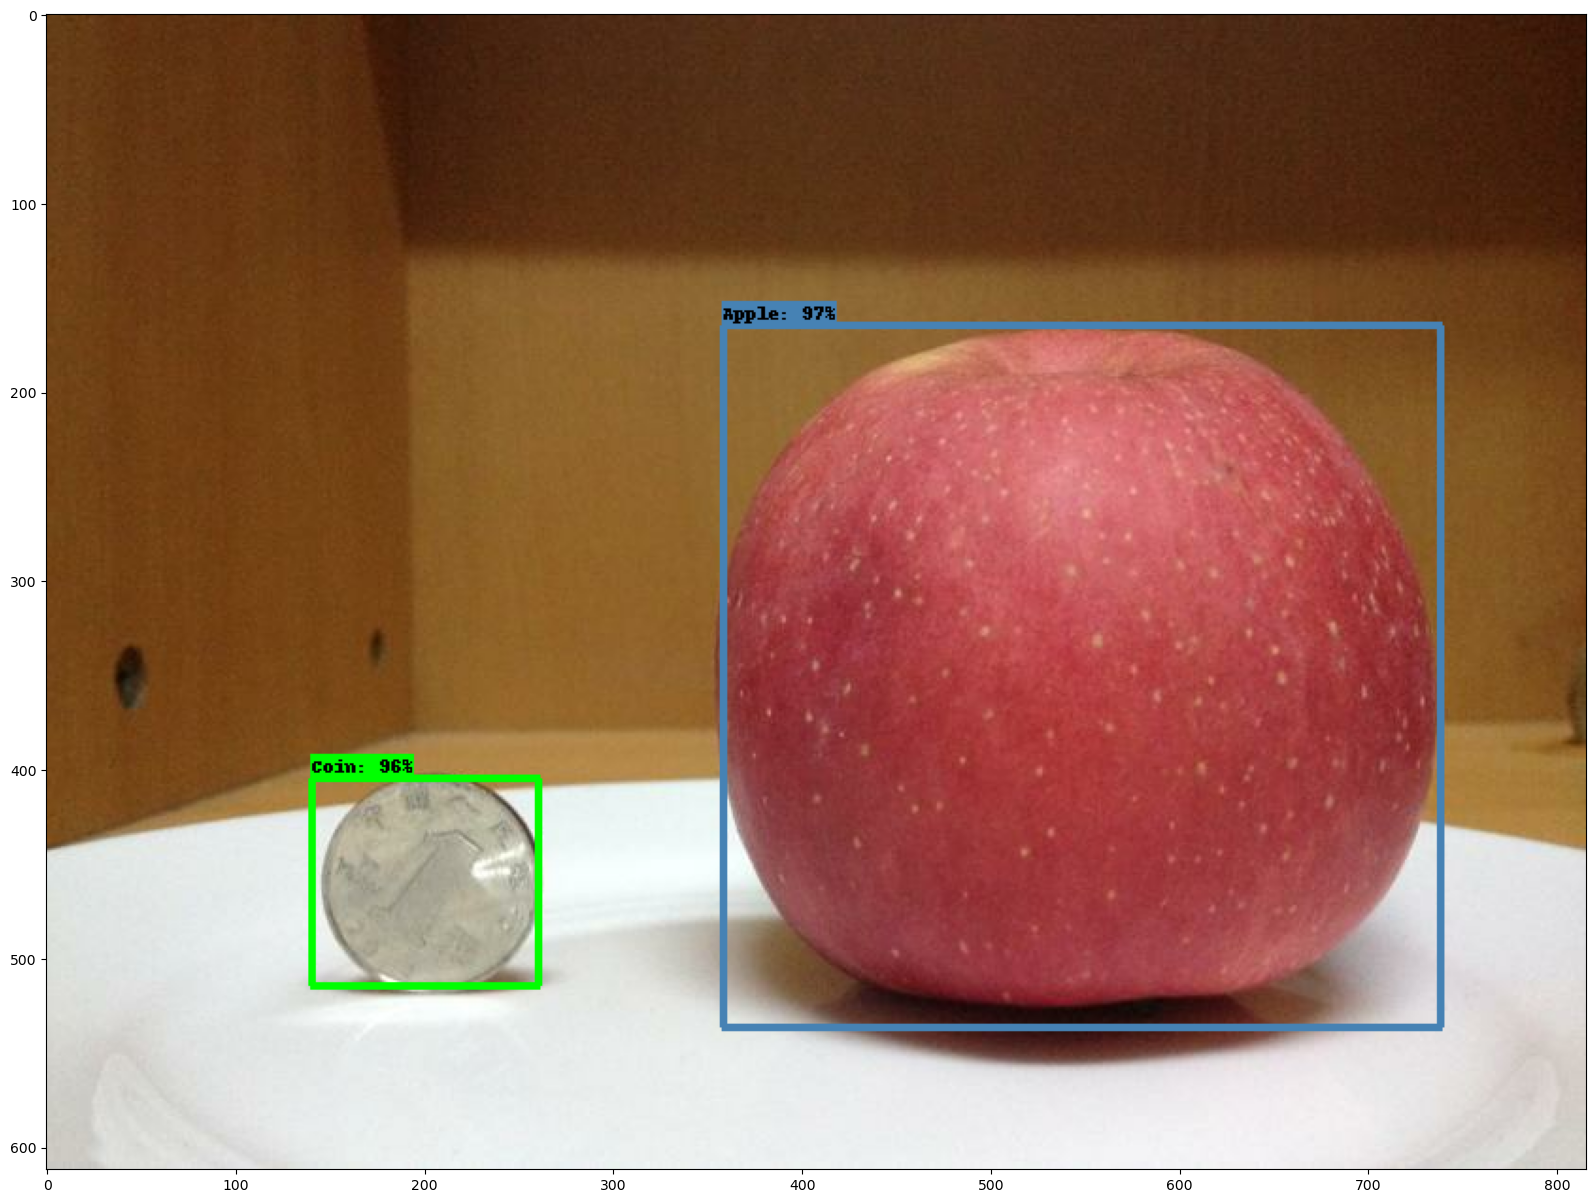

In [36]:
image_with_boxes, detections = run_detector(detector, image_path)
display_image(image_with_boxes)

In [ ]:
def read_label_map(label_map_path):
    category_index = {}
    with open(label_map_path, 'r') as f:
        lines = f.readlines()
        name = None
        display_name = None  # Inizializza display_name come None
        for line in lines:
            line = line.strip()
            if line.startswith('name:'):
                name = line[len('name:'):].strip().strip('\'"')
            elif line.startswith('display_name:'):  # Controlla se è presente display_name
                display_name = line[len('display_name:'):].strip().strip('\'"')
            elif line.startswith('id:'):
                class_id = int(line[len('id:'):])
                category_index[class_id] = {'id': class_id, 'name': name, 'display_name': display_name}
    return category_index

In [141]:
import cv2

def run_grabcut(image_path, detections, class_names):
    # Load the image
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    for box, class_names, score in zip(detections['detection_boxes'], detections['detection_class_labels'], detections['detection_scores']):
        # Convert the bounding box from fractions to pixel coordinates
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

        print(category_index[class_names]['name'])

        if category_index[class_names]['display_name'] == 'Apple':
            # Create a mask with zeros, same size as the image
            mask = np.zeros((height, width), np.uint8)

            # Create a binary mask with foreground set to 1 inside the bounding box
            mask[ymin:ymax, xmin:xmax] = 1

            # Initialize the GrabCut algorithm
            bgd_model = np.zeros((1, 65), np.float64)
            fgd_model = np.zeros((1, 65), np.float64)

            # Run the GrabCut algorithm with the initial mask
            cv2.grabCut(image, mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

            # Create a binary mask where the foreground is True (3 and 1 are the possible states of the mask)
            mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

            # Multiply the original image with the binary mask to get the segmented image
            segmented_image = image * mask2[:, :, np.newaxis]

            # Display the original image and the segmented image
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('Segmented Image')

            plt.show()
  

In [142]:
# Load the label map and create category_index
label_map_path = '..\\tf_models\\research\\object_detection\\data\\oid_bbox_trainable_label_map.pbtxt' # Replace with the path to your label map file'
category_index = None 

if os.path.isfile(label_map_path):
    print("Il file esiste nel percorso specificato.")

    with open(label_map_path, 'r') as f:
        label_map = f.read()

    # Prosegui con la creazione di category_index solo se esiste label_map
    category_index = read_label_map(label_map_path)

    if category_index:
        for category_info in category_index.values():
            print(f"Categoria ID: {category_info['id']}, Nome: {category_info['display_name']}")
    else:
        print("Il file label_map è vuoto o non ha categorie definite.")
else:
    print("Il file NON esiste nel percorso specificato.")

# Get the class names from the dictionary
#class_names = [category_info['display_name'] for category_info in category_index.values()] if category_index else []
class_names = [category_info.get('display_name', category_info['name']) for category_info in category_index.values()] if category_index else []

run_grabcut(image_path, detections,class_names)

Il file esiste nel percorso specificato.
Categoria ID: 1, Nome: None
Categoria ID: 2, Nome: Person
Categoria ID: 3, Nome: Clothing
Categoria ID: 4, Nome: Man
Categoria ID: 5, Nome: Face
Categoria ID: 6, Nome: Tree
Categoria ID: 7, Nome: Plant
Categoria ID: 8, Nome: Woman
Categoria ID: 9, Nome: Vehicle
Categoria ID: 10, Nome: Building
Categoria ID: 11, Nome: Land vehicle
Categoria ID: 12, Nome: Footwear
Categoria ID: 13, Nome: Girl
Categoria ID: 14, Nome: Animal
Categoria ID: 15, Nome: Car
Categoria ID: 16, Nome: Food
Categoria ID: 17, Nome: Wheel
Categoria ID: 18, Nome: Flower
Categoria ID: 19, Nome: Furniture
Categoria ID: 20, Nome: Window
Categoria ID: 21, Nome: House
Categoria ID: 22, Nome: Boy
Categoria ID: 23, Nome: Fashion accessory
Categoria ID: 24, Nome: Table
Categoria ID: 25, Nome: Glasses
Categoria ID: 26, Nome: Suit
Categoria ID: 27, Nome: Auto part
Categoria ID: 28, Nome: Bird
Categoria ID: 29, Nome: Sports equipment
Categoria ID: 30, Nome: Dress
Categoria ID: 31, Nome: Do

KeyError: 559